In [2]:
using Pkg

Pkg.activate("..")

  Activating project at `~/Projects/Working/HIFMB/TempRanges`


In [3]:
using Distributions
using UUIDs
using LinearAlgebra
using StatsBase
using CairoMakie
using JLD2

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]


In [3]:
include("../code/foodwebs/FoodWebs.jl")
fw = FoodWebs

Main.FoodWebs

In [4]:
#construct global species list
Npool = 500
Tpk = rand(Npool) * (π/2)
sp_vec = fw.species(0.1,Tpk,Npool)


T_vec = range(0,π/2, length = 50)
ind = [fw.sample_community(25, T, sp_vec, d -> exp(-100abs(d)) ) for (i,T) = enumerate(T_vec)]
coms = [fw.community(sp_vec[ind[i]], loc = (0, T)) for (i,T) = enumerate(T_vec)]

fw.metacommuntiy(coms)

MetaCommunity M:50 Main.FoodWebs.Community Sp: 486

In [5]:
#creating a stable metacommunity
function get_stable_com(sp_vec, lonlat, θ = 0.75, fe::Function = fw.random_parameters)
    psw = 0.0
    com = 0
    while psw < θ
        sp_filter = sp_vec[fw.sample_community(30, lonlat[2], sp_vec, d -> exp(-10abs(d)))]
        com = fw.community(sp_filter, loc = lonlat)
        if com.N > 20
            psw = fw.proportion_stable_webs(com, fw.random_parameters, N_trials = 100)
        end
    end
    return(com)
end

function get_stable_metacom(sp_vec, lonlat, θ = 0.7, fe::Function = fw.random_parameters)
    coms = Vector{fw.Community}(undef, length(lonlat))
    for t = 1:length(lonlat)
        coms[t] = get_stable_com(sp_vec, lonlat[t], θ, fe)
    end
    
    return(fw.metacommuntiy(coms))
end

get_stable_metacom (generic function with 3 methods)

In [6]:
function get_disperal_lists(mc, ΔT; fpd::Function = d -> exp(-10abs(d)), αd = 0.75)
    #find maximum distance
    M = vcat([s.M for s = mc.sp]...)
    d = M .^ αd
    dmax =  d ./ maximum(d)
    
    #loop through species and find dispersal
    from = Vector{Vector{Int}}(undef, length(mc.sp))
    to = Vector{Vector{Int}}(undef, length(mc.sp))
    
    for i = 1:length(mc.sp)
        sp = mc.sp[i]
        
        #caluculate distances
        reachable = dmax[i] .> mc.D[mc.sp_loc[sp.id],:]
        
        pd_after = fpd.(mc.T_mat .- sp.Tpk .- ΔT) 
        
        #combine to get probabilities to test
        to_test = vcat([findall(r) for r = eachrow(reachable)]...)
        to_disperse = rand(length(to_test)) .< pd_after[to_test]
        from[i] = deepcopy(mc.sp_loc[sp.id])
        to[i] = unique(to_test[to_disperse])
    end

    return(from,to)
end

get_disperal_lists (generic function with 1 method)

In [7]:
function move_and_remove!(mc, from, to)
    # #move and remove species
    for i = 1:length(mc.sp)
        #add species  
        for t = to[i]
            if t ∉ from[i]
                fw.add_sp_meta!(mc, t, mc.sp[i])
            end
        end
        #remove species
        for f = from[i]
            if f ∉ to[i]
                fw.remove_sp_meta!(mc, f, mc.sp[i].id)
            end
        end
    end
end

move_and_remove! (generic function with 1 method)

In [8]:
lonlat = fw.sample_lonlat(50)
mc = get_stable_metacom(sp_vec, lonlat, 0.75)

fw.check_metacommunity(mc)

In [9]:
function exp_parameters(N::Int64, M::Int64)
    #exponent
    γ = rand(Uniform(0.8, 1.5), N, M) #[0.8, 1.5]
    λ = ones(N,N) # 1
    μ = rand(Uniform(1.0, 2.0), N, M) #[1.0, 2.0] 
    ϕ = rand(Uniform(0.0, 1.0), N, M) #[0.0, 1.0]
    ψ = rand(Uniform(0.5,1.2), N, M) #[0.5, 1.2]

    return [fw.ExponentialParameters(γ[:,i], λ, μ[:,i], ϕ[:,i], ψ[:,i]) for i = 1:M]
end

function mean_M(com)
    if com.N > 0
        return mean([s.M[1] for s = com.sp])
    else
        return 0
    end
end

mean_M (generic function with 1 method)

In [ ]:
Npool = 250
Tpk = rand(Npool) * (π/2)
sp_vec = fw.species(0.1,Tpk,Npool)

Nrep = 100
NT = 50
Nα = range(-0.75,0.75, length = 5)
NΔT = range(0.0, 0.5, length = 5)

results_psw = zeros(Nrep, 2, 5, 5, NT)
results_N = zeros(Nrep, 2, 5, 5, NT)
results_M = zeros(Nrep, 2, 5, 5, NT)

itt = [0]
for (i,v) = enumerate(Nα)
    for (j,w) = enumerate(NΔT)
        print("\r $i  $j")
        Threads.@threads for k = 1:Nrep
                itt[1] += 1
                # print("\r",itt[1])
            
                lonlat = fw.sample_lonlat(NT)
                mc = get_stable_metacom(sp_vec, lonlat, 0.75)
            
                results_psw[k,1,i,j,:] .= fw.proportion_stable_webs(mc, exp_parameters)
                results_N[k,1,i,j,:] .= [c.N for c = mc.coms]
                results_M[k,1,i,j,:] .= mean_M.(mc.coms)
        
                f,t = get_disperal_lists(mc, w, αd = v)
                move_and_remove!(mc, f, t)
            
                results_psw[k,2,i,j,:] .= fw.proportion_stable_webs(mc, exp_parameters)
                results_N[k,2,i,j,:] .= [c.N for c = mc.coms]
                results_M[k,2,i,j,:] .= mean_M.(mc.coms)
        end
    end
end
        

 1  2

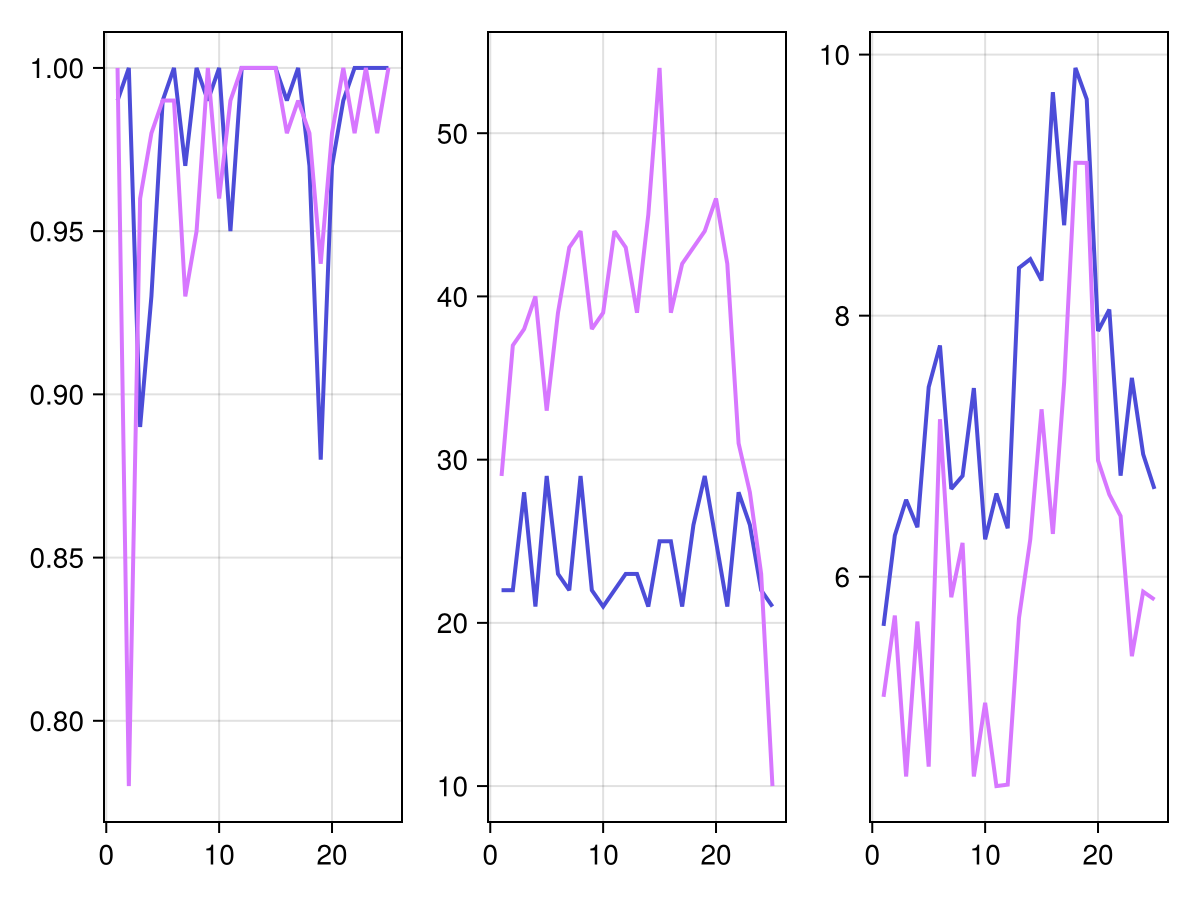

In [13]:
f = Figure()
ax = Axis(f[1,1])
series!(ax, mean(results_psw, dims = 1)[1,:,1,1,:])
ax = Axis(f[1,2])
series!(ax, mean(results_N, dims = 1)[1,:,1,1,:])
ax = Axis(f[1,3])
series!(ax, mean(log.(results_M), dims = 1)[1,:,1,1,:])
f

In [86]:
lonlat = fw.sample_lonlat(50)
mc = get_stable_metacom(sp_vec, lonlat, 0.75)

MetaCommunity M:50 Main.FoodWebs.Community Sp: 414

In [75]:
x = JLD2.load("../results/results.jld2")

Dict{String, Any} with 3 entries:
  "M"   => [942.125 3066.79; 556.113 3066.79; … ; 682.44 1764.0; 1080.82 3066.7…
  "N"   => [27.0 3.0; 21.0 3.0; … ; 24.0 2.0; 23.0 3.0;;; 22.0 1.0; 23.0 3.0; ……
  "psw" => [1.0 0.85; 0.97 0.96; … ; 0.98 0.9; 0.99 0.86;;; 0.97 0.99; 0.85 0.9…

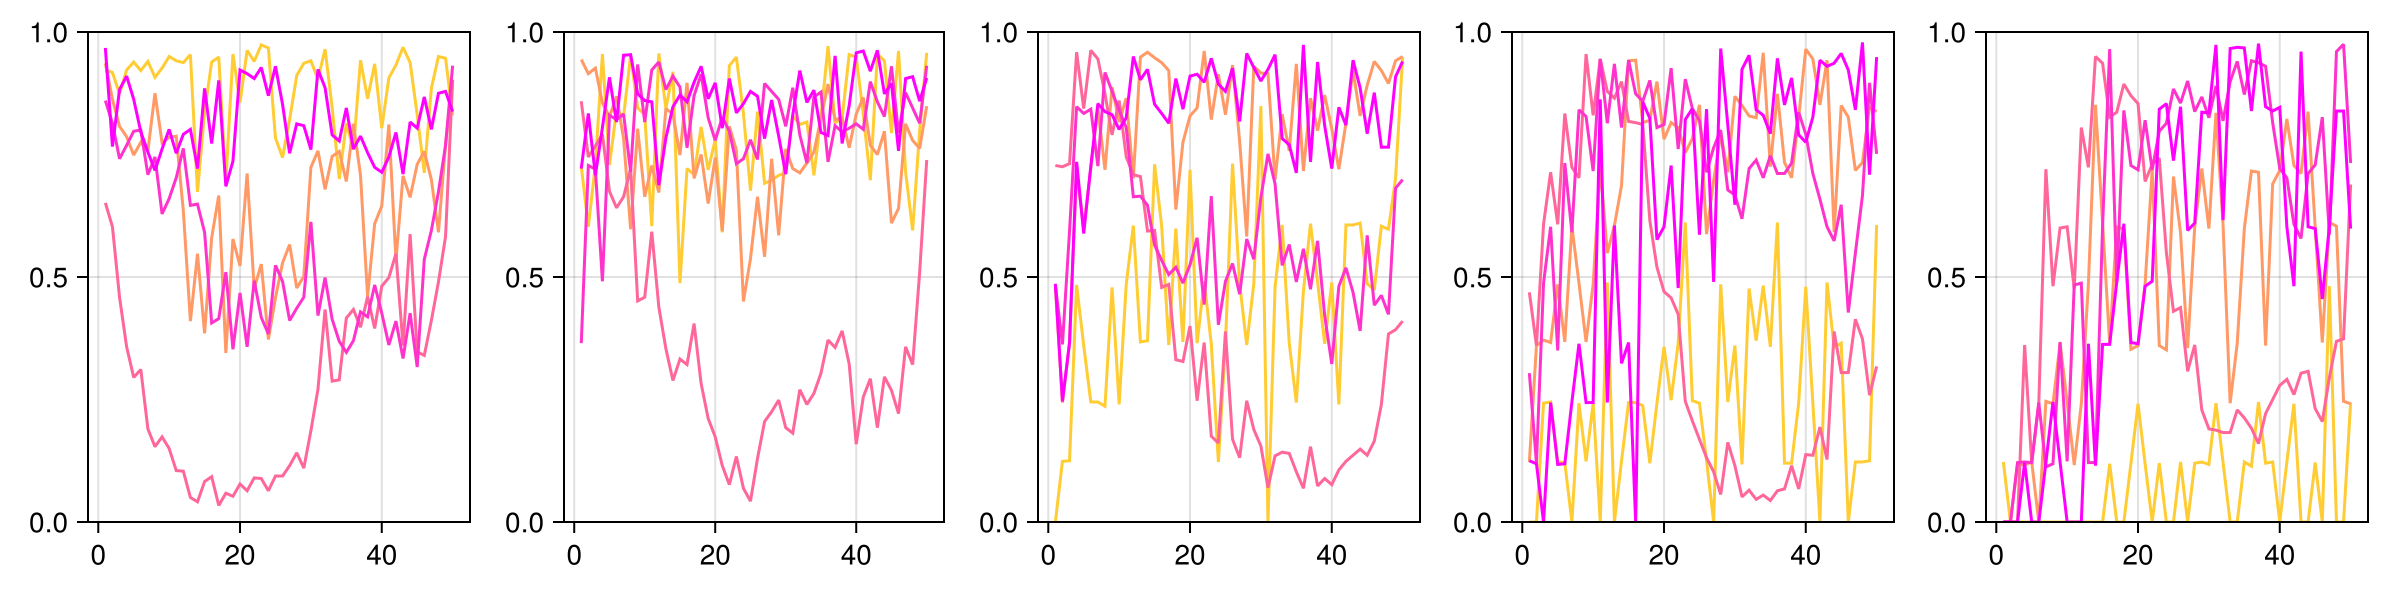

In [76]:
psw = mean(x["psw"], dims = 1)[1,:,:,:,:]

f = Figure(size = (1200, 300))

ax = [Axis(f[1,k]) for k = 1:5]

for k = 1:5
    for i = 1:5
        lines!(ax[k], psw[2,i,k,:], color = RGBf(1,1 - i/5,i/5))
        # for j = 1:50
            # scatter!(ax[k], 1:50, x["psw"][j,2,k,i,:], color = (RGBf(1,1 - i/5,i/5), 0.05))
        # end
        # series!(ax, x["psw"][:,2,i,3,:], solid_color = :black, marker = true)
    end
end
ylims!.(ax, 0,1)
f

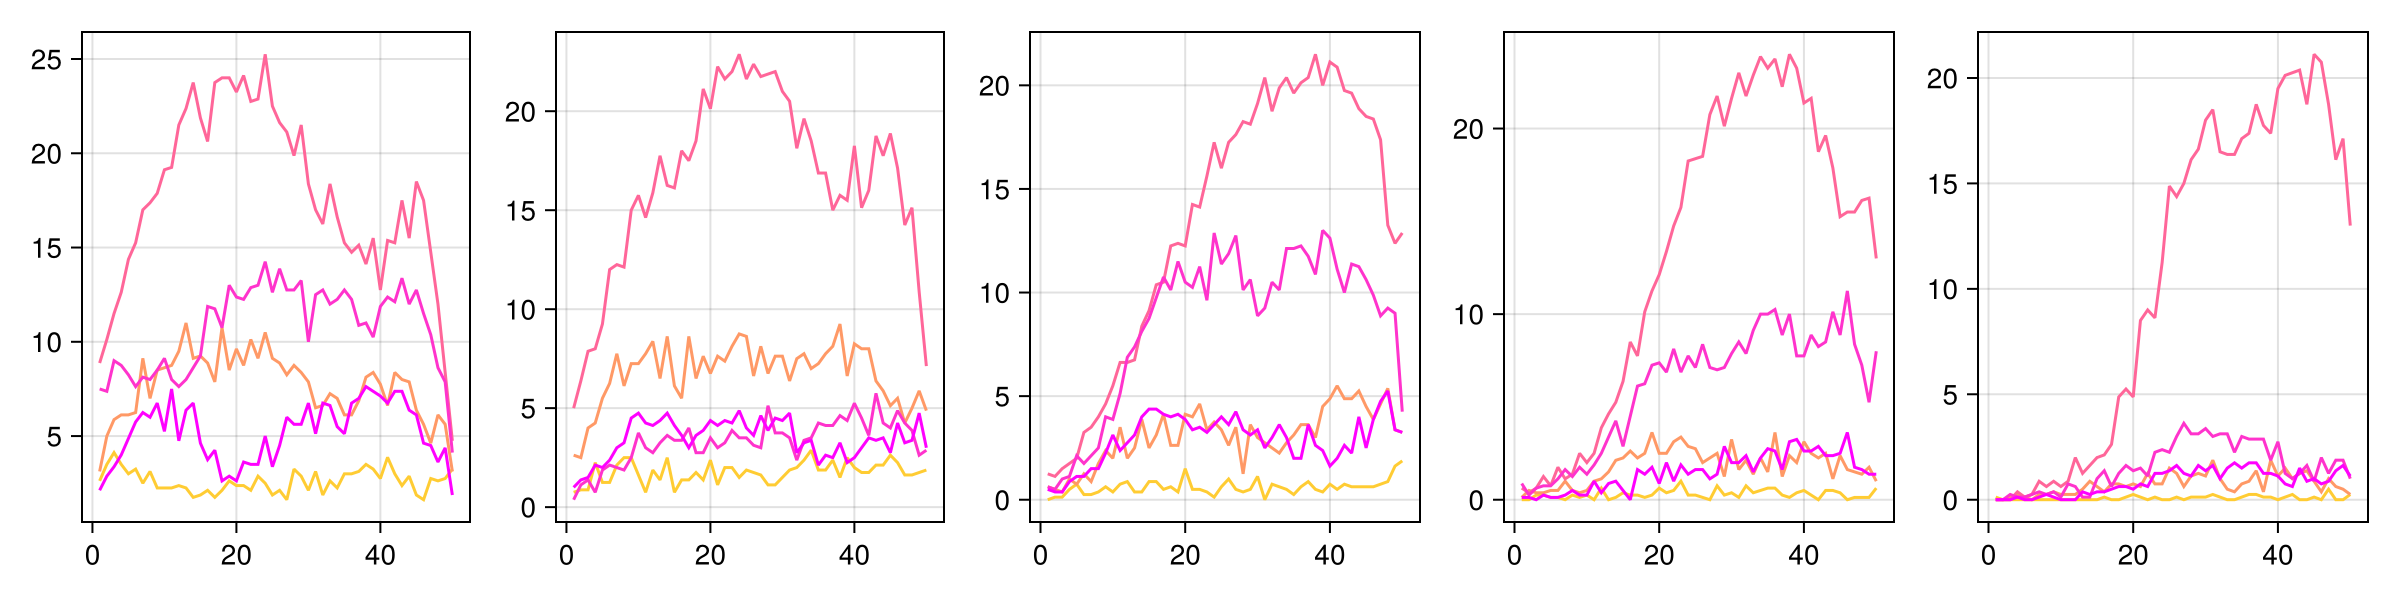

In [77]:
N = mean(x["N"], dims = 1)[1,:,:,:,:]

f = Figure(size = (1200, 300))

ax = [Axis(f[1,k]) for k = 1:5]

for k = 1:5
    for i = 1:5
        lines!(ax[k], N[2,i,k,:], color = RGBf(1,1 - i/5,i/5))
        # for j = 1:50
            # scatter!(ax[k], 1:50, x["psw"][j,2,k,i,:], color = (RGBf(1,1 - i/5,i/5), 0.05))
        # end
        # series!(ax, x["psw"][:,2,i,3,:], solid_color = :black, marker = true)
    end
end
f

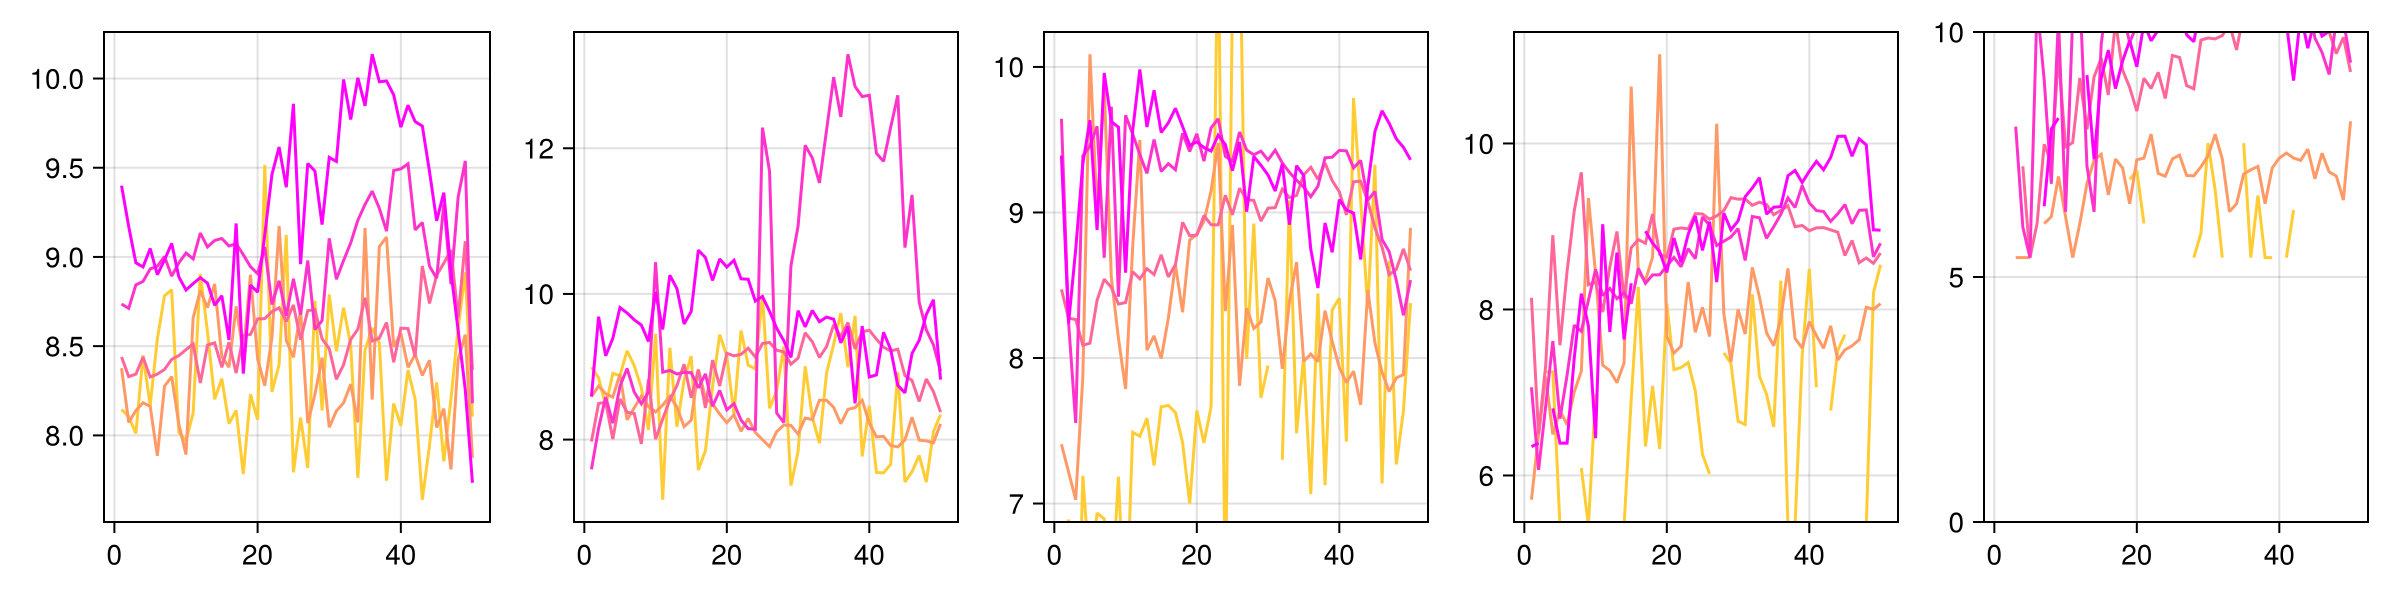

In [78]:
M = mean(x["M"], dims = 1)[1,:,:,:,:]

f = Figure(size = (1200, 300))

ax = [Axis(f[1,k]) for k = 1:5]

for k = 1:5
    for i = 1:5
        lines!(ax[k], log.(M[2,i,k,:]), color = RGBf(1,1 - i/5,i/5))
        # for j = 1:50
            # scatter!(ax[k], 1:50, x["psw"][j,2,k,i,:], color = (RGBf(1,1 - i/5,i/5), 0.05))
        # end
        # series!(ax, x["psw"][:,2,i,3,:], solid_color = :black, marker = true)
    end
end
f

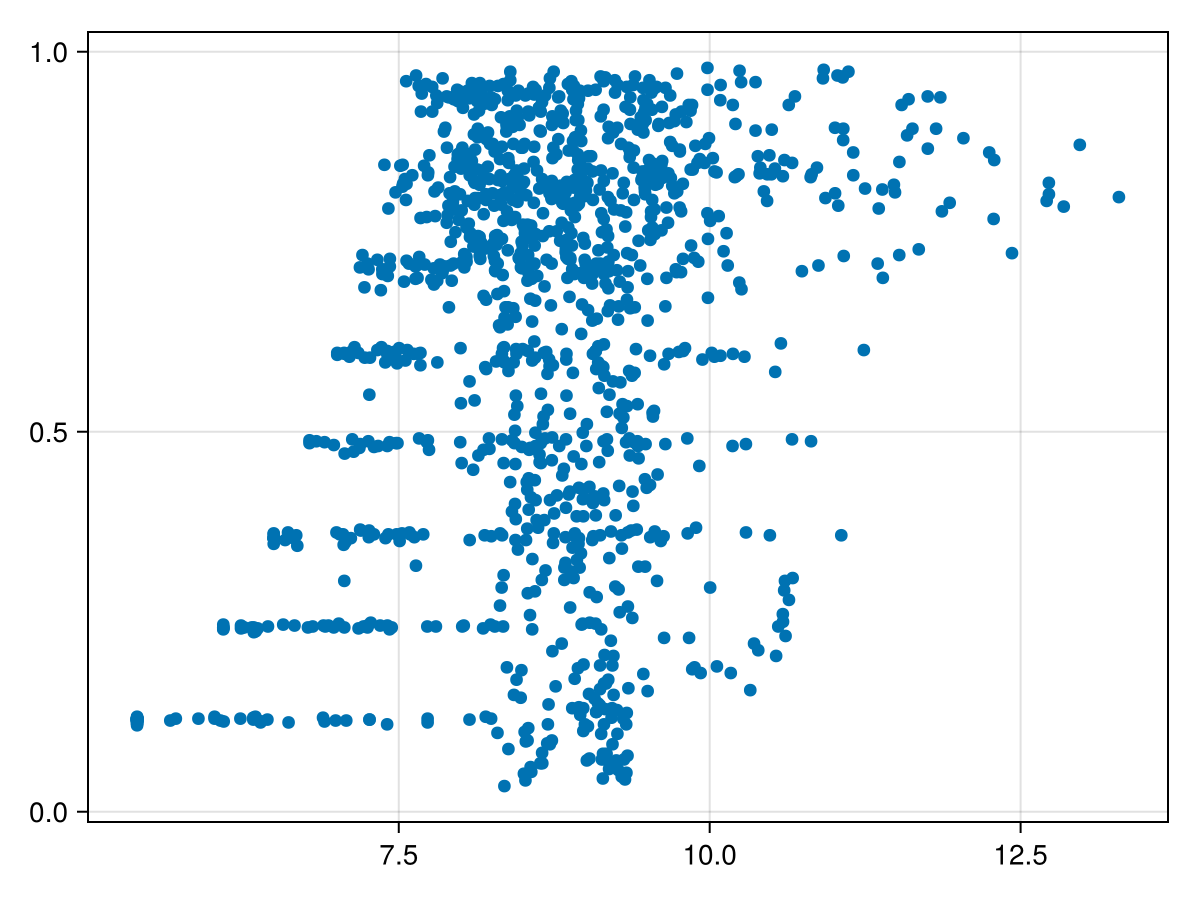

In [85]:
ind = M[2,:,:,:][:] .!= 0

plot(log.(M[2,:,:,:][ind]), psw[2,:,:,:][ind])